In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('text.latex', preamble=r'\usepackage{libertine}')

In [3]:
import glob
import json

def load_json_infos(base_folder):
    files = glob.glob(base_folder + '/*.json')
    data = {}
    for file in files:
        with open(file) as f:
            content = f.read()
            
        json_data = json.loads(content)
        run_type = file.split('/')[-1]
        sects = {item.split(':')[0]: item.split(':')[1] for item in run_type.split('_') if ":" in item}
        json_data['type'] = sects
        data[run_type] = json_data
    return data

In [4]:
from matplotlib.path import Path
verts = [
   (-3, -1.),  # left, bottom
   (-3, 1.),  # left, top
   (3, 1.),  # right, top
   (3, -1.),  # right, bottom
   (-3, -1.),  # ignored
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

my_path = Path(verts, codes)

In [5]:
def plot_policy_median_times(data_list, data_cats, title, filename, ymax, x_label='Simulated learner',
                             group_labels=None, y_label='Seconds', legend=True, error_bars=None):
    if group_labels is None:
        group_labels = ['Memoryless', 'Memory', 'Continuous']

    x = np.arange(len(group_labels))  # the x locations for the groups
    width = 0.14  # the width of the bars

    elinewidth = 0.6
    
    start_x = x - 2.5*width
    for idx, data_cat in enumerate(data_list):
        yerr = None
        if error_bars is not None:
            yerr = error_bars[idx, :]
            for ii, med in enumerate(data_cat):
                yerr[ii] -= med
            yerr = np.abs(yerr.T)

        bar_cur = plt.bar(start_x, data_cat, width-0.01, label=data_cats[idx],
                yerr=yerr, error_kw={'elinewidth': elinewidth})
        start_x += 1*width
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.ylabel(r'\textbf{' + y_label + '}')
    plt.title(r'\textbf{' + title + '}')
    plt.xticks(x, group_labels)
    plt.xlabel(r'\textbf{' + x_label + '}')
    
    if legend:
        plt.legend(frameon=True)

    plt.yticks([i for i in range(0, ymax+1, 100)])
    plt.ylim(0, ymax)

In [6]:
def plot_policy_median_times_orig(data_list, data_cats, title, filename, ymax, x_label='Simulated learner',
                             group_labels=None, y_label='Seconds', legend=True, error_bars=None,
                             highlight=None):
    
    if group_labels is None:
        group_labels = ['Memoryless', 'Memory', 'Continuous']

    x = np.arange(len(group_labels))  # the x locations for the groups
    width = 0.14  # the width of the bars

    elinewidth = 0.6
    
    bw_colors = [['#444444']*3, ['#666666']*3, ['#888888']*3, ['#AAAAAA']*3, ['#CCCCCC']*3, ['#EEEEEE']*3]
    
    if highlight is not None:
        for h_id in highlight:
            h_id -= 1
            g_id = h_id % 6
            e_id = h_id // 6
            bw_colors[g_id][e_id] = '#EEAAAA'
    

    start_x = x - 2.5*width
    for idx, data_cat in enumerate(data_list):
        yerr = None
        if error_bars is not None:
            yerr = error_bars[idx, :]
            for ii, med in enumerate(data_cat):
                yerr[ii] -= med
            yerr = np.abs(yerr.T)

        bar_cur = plt.bar(start_x, data_cat, width-0.01, label=data_cats[idx],
                yerr=yerr, error_kw={'elinewidth': elinewidth}, color=bw_colors[idx], edgecolor='black')
        start_x += 1*width
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.ylabel(r'\textbf{' + y_label + '}')
    plt.title(r'\textbf{' + title + '}')
    plt.xticks(x, group_labels)
    plt.xlabel(r'\textbf{' + x_label + '}')
    if legend:
        markers = [plt.Line2D([0,0],[0,0],color=color, marker=my_path, markersize=20, markeredgecolor='black',
                              linestyle='')
                   for color in ['#444444', '#666666', '#888888', '#AAAAAA', '#CCCCCC', '#EEEEEE']]
        plt.legend(markers, data_cats, frameon=True)

    plt.yticks([i for i in range(0, ymax+1, 100)])
    plt.ylim(0, ymax)

In [7]:
def plot_actions(data, title, legend=True):
    with plt.style.context('science'):
        #fig, ax = plt.subplots(figsize=(8, 2))

        y = np.arange(len(data[:,0]))

        plt.bar(y, data[:,0], label='Example')
        plt.bar(y, data[:,1], label='Quiz', bottom=data[:,0])
        plt.bar(y, data[:,2], label='Feedback', bottom=data[:,1]+data[:,0])

        plt.ylabel(r'\textbf{Count}')
        plt.xlabel(r'\textbf{Action number}')
        plt.title(title)
        if legend:
            plt.legend(frameon=True)

        plt.ylim(0, np.max(data))

In [8]:
def read_times_from_json(base_dir):
    all_data = load_json_infos(base_dir)
    learn_times = [
        {
            'model': item['type']['model'],
            'learner': item['type']['sim'],
            'times': {
                'median': item['stats'][0][1],
                'ci_lower': item['stats'][0][2],
                'ci_upper': item['stats'][0][3],
            }
        }
        for item in all_data.values()
    ]
    times_dict = {'memoryless': {}, 'discrete': {}, 'continuous': {}, 'random': {}, 'mig': {}, 'random-qe': {}}

    for item in learn_times:
        times_dict[item['model']][item['learner']] = item['times']
    
    data_times = np.array([
        [times_dict['random']['memoryless']['median'], 
         times_dict['random']['discrete']['median'], 
         times_dict['random']['continuous']['median']],

        [times_dict['random-qe']['memoryless']['median'], 
         times_dict['random-qe']['discrete']['median'], 
         times_dict['random-qe']['continuous']['median']],

        [times_dict['mig']['memoryless']['median'], 
         times_dict['mig']['discrete']['median'], 
         times_dict['mig']['continuous']['median']],

        [times_dict['memoryless']['memoryless']['median'], 
         times_dict['memoryless']['discrete']['median'], 
         times_dict['memoryless']['continuous']['median']],

        [times_dict['discrete']['memoryless']['median'], 
         times_dict['discrete']['discrete']['median'], 
         times_dict['discrete']['continuous']['median']],

        [times_dict['continuous']['memoryless']['median'], 
         times_dict['continuous']['discrete']['median'], 
         times_dict['continuous']['continuous']['median']],
    ], dtype=float)

    data_times_ci = np.array([
        [[times_dict['random']['memoryless']['ci_lower'], times_dict['random']['memoryless']['ci_upper']], 
         [times_dict['random']['discrete']['ci_lower'], times_dict['random']['discrete']['ci_upper']], 
         [times_dict['random']['continuous']['ci_lower'], times_dict['random']['continuous']['ci_upper']]],

        [[times_dict['random-qe']['memoryless']['ci_lower'], times_dict['random-qe']['memoryless']['ci_upper']], 
         [times_dict['random-qe']['discrete']['ci_lower'], times_dict['random-qe']['discrete']['ci_upper']], 
         [times_dict['random-qe']['continuous']['ci_lower'], times_dict['random-qe']['continuous']['ci_upper']]],

        [[times_dict['mig']['memoryless']['ci_lower'], times_dict['mig']['memoryless']['ci_upper']], 
         [times_dict['mig']['discrete']['ci_lower'], times_dict['mig']['discrete']['ci_upper']], 
         [times_dict['mig']['continuous']['ci_lower'], times_dict['mig']['continuous']['ci_upper']]],

        [[times_dict['memoryless']['memoryless']['ci_lower'], times_dict['memoryless']['memoryless']['ci_upper']], 
         [times_dict['memoryless']['discrete']['ci_lower'], times_dict['memoryless']['discrete']['ci_upper']], 
         [times_dict['memoryless']['continuous']['ci_lower'], times_dict['memoryless']['continuous']['ci_upper']]],

        [[times_dict['discrete']['memoryless']['ci_lower'], times_dict['discrete']['memoryless']['ci_upper']], 
         [times_dict['discrete']['discrete']['ci_lower'], times_dict['discrete']['discrete']['ci_upper']], 
         [times_dict['discrete']['continuous']['ci_lower'], times_dict['discrete']['continuous']['ci_upper']]],

        [[times_dict['continuous']['memoryless']['ci_lower'], times_dict['continuous']['memoryless']['ci_upper']], 
         [times_dict['continuous']['discrete']['ci_lower'], times_dict['continuous']['discrete']['ci_upper']], 
         [times_dict['continuous']['continuous']['ci_lower'], times_dict['continuous']['continuous']['ci_upper']]],

    ], dtype=float)
    
    return data_times, data_times_ci

In [9]:
def read_action_stats_from_jsons(base_dir, max_steps=120):
    all_data = load_json_infos(base_dir)
    
    actions_map = {
        "EXAMPLE": 0,
        "QUIZ": 1,
        "FEEDBACK": 2
    }

    action_stats = {'memoryless': [], 'continuous': [], 'discrete': [], 'random': [], 'random-qe': [], 'mig': []}

    for item in all_data.values():
        action_stats[item['type']['model']].append([[actions_map[action[0]] for action in run] for run in item['actions']])

    actions_cont = np.zeros((max_steps, 3), dtype=int)
    [[[add_action(actions_cont, step, action, 1)
        for step, action in enumerate(trial)] for trial in trials] for trials in action_stats['continuous']]

    actions_disc = np.zeros((max_steps, 3), dtype=int)
    [[[add_action(actions_disc, step, action, 1)
        for step, action in enumerate(trial)] for trial in trials] for trials in action_stats['discrete']]

    actions_mless = np.zeros((max_steps, 3), dtype=int)
    [[[add_action(actions_mless, step, action, 1)
        for step, action in enumerate(trial)] for trial in trials] for trials in action_stats['memoryless']]

    return actions_mless, actions_disc, actions_cont

In [10]:
data_cats = ['Random', 'QE only', 'Max. Info. Gain', 'Memoryless', 'Memory', 'Continuous']

In [11]:
def add_action(container, step, t, count):
    container[step, t] += count

# Letter arithmetic

### No precomputation

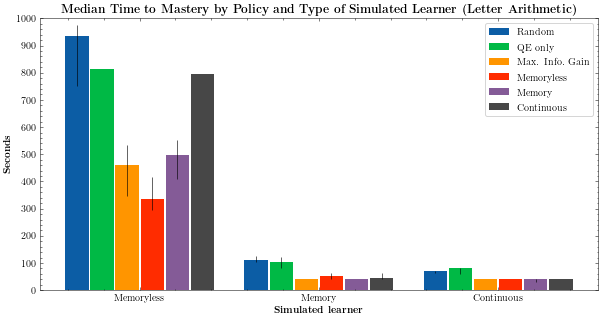

In [12]:
data_letter2, data_letter_ci2 = read_times_from_json('./data/letter/nopre')

with plt.style.context('science'):
    plt.figure(figsize=(10,5))
    plot_policy_median_times(data_letter2, data_cats,
                             'Median Time to Mastery by Policy and Type of Simulated Learner (Letter Arithmetic)', 
                             'median-time-letter', ymax=1000, error_bars=data_letter_ci2)
    plt.savefig('figures/median-time-letter-nopre.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

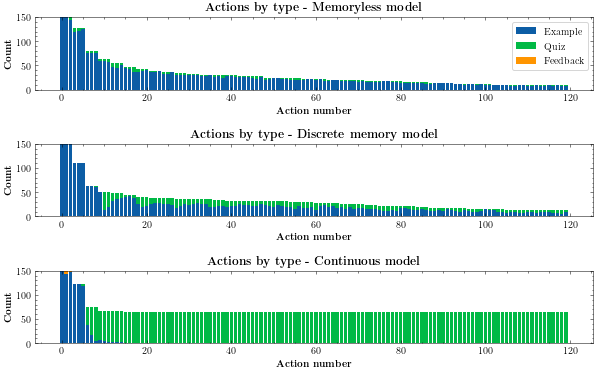

In [13]:
letter_actions_mless, letter_actions_disc, letter_actions_cont = \
    read_action_stats_from_jsons('./data/letter/nopre')

with plt.style.context('science'):
    plt.figure(figsize=(10,6))
    plt.subplot(311)
    plot_actions(letter_actions_mless, r'\textbf{Actions by type - Memoryless model}')
    plt.subplot(312)
    plot_actions(letter_actions_disc, r'\textbf{Actions by type - Discrete memory model}', legend=False)
    plt.subplot(313)
    plot_actions(letter_actions_cont, r'\textbf{Actions by type - Continuous model}', legend=False)
    plt.subplots_adjust(hspace=.75)
    plt.savefig("figures/letter-actions-nopre.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

### With precomputation

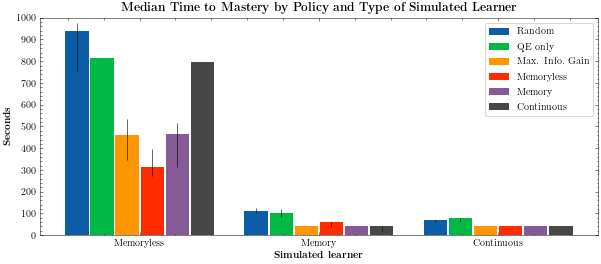

In [14]:
data_letter = np.array([
    [936.8, 110.5, 68.9],
    [814.4, 102.2, 80.8],
    [462.0, 42.0, 42.0],
    [313.2, 62.6, 42.0],
    [466.1, 42.0, 42.0],
    [794.8, 42.0, 42.0]
])

data_letter_ci = np.array([
    [[751.8, 976.6], [102, 125.4], [61.6, 71.6]],
    [[814, 815.2], [82, 121.6], [61.4, 81.2]],
    [[346.5, 535.5], [42, 42], [42, 42]],
    [[271.0, 396.2], [42, 62.6], [42, 42]],
    [[311.4, 517.0], [42, 42], [42, 42]],
    [[794.8, 794.8], [21, 42], [42, 42]],
])

with plt.style.context('science'):
    plt.figure(figsize=(10,4))
    plot_policy_median_times(data_letter, data_cats,
                             'Median Time to Mastery by Policy and Type of Simulated Learner', 
                             'median-time-letter', ymax=1000, error_bars=data_letter_ci.copy())
    plt.savefig('figures/median-time-letter-pre.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

In [15]:
from functools import reduce
from tabulate import tabulate

medians = reduce(lambda x, carry: x+carry, data_letter.tolist())
cis = reduce(lambda x, carry: x+carry, data_letter_ci.tolist())
combined = [[md, ci[0], ci[1]] for md, ci in zip(medians, cis)]

tbl = []
for els in combined:
    tbl.append(("{:.2f}".format(els[0]), "[{:.1f} {:.1f}]".format(els[1], els[2])))
    

print(tabulate(tbl, tablefmt='latex'))

\begin{tabular}{rl}
\hline
 936.8 & [751.8 976.6] \\
 110.5 & [102.0 125.4] \\
  68.9 & [61.6 71.6]   \\
 814.4 & [814.0 815.2] \\
 102.2 & [82.0 121.6]  \\
  80.8 & [61.4 81.2]   \\
 462   & [346.5 535.5] \\
  42   & [42.0 42.0]   \\
  42   & [42.0 42.0]   \\
 313.2 & [271.0 396.2] \\
  62.6 & [42.0 62.6]   \\
  42   & [42.0 42.0]   \\
 466.1 & [311.4 517.0] \\
  42   & [42.0 42.0]   \\
  42   & [42.0 42.0]   \\
 794.8 & [794.8 794.8] \\
  42   & [21.0 42.0]   \\
  42   & [42.0 42.0]   \\
\hline
\end{tabular}


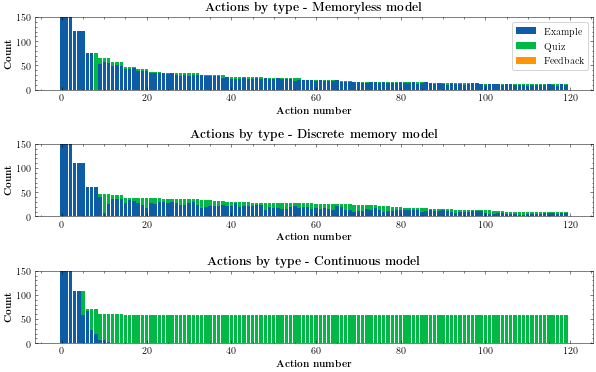

In [16]:
# cont model
letter_actions_cont_cont = [[50, 50, 50, 31, 31, 31, 3, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
letter_actions_cont_disc = [[50, 50, 50, 27, 27, 27, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 19, 19, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
letter_actions_cont_mless = [[50, 50, 50, 50, 50, 0, 45, 27, 18, 6, 7, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 50, 4, 22, 31, 41, 40, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 45, 46, 46, 46, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

letter_actions_cont = np.zeros((120, 3))
[[[add_action(letter_actions_cont, step, t, count)
 for step, count in enumerate(seq)] for t, seq in enumerate(var)]
 for var in [letter_actions_cont_cont, letter_actions_cont_disc, letter_actions_cont_mless]]

# discrete memory model
letter_actions_disc_cont = [[50, 50, 50, 31, 31, 31, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
letter_actions_disc_disc = [[50, 50, 50, 30, 30, 30, 14, 14, 14, 3, 0, 3, 3, 3, 3], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
letter_actions_disc_mless = [[50, 50, 50, 49, 49, 49, 45, 45, 45, 38, 6, 22, 33, 32, 33, 28, 33, 32, 27, 23, 18, 27, 26, 29, 30, 27, 30, 28, 24, 24, 28, 29, 23, 18, 20, 22, 21, 21, 23, 21, 21, 27, 19, 21, 22, 22, 23, 23, 13, 19, 18, 17, 16, 16, 20, 21, 18, 19, 20, 16, 17, 15, 17, 16, 14, 21, 20, 14, 13, 10, 12, 12, 15, 14, 18, 13, 10, 11, 11, 14, 13, 14, 14, 14, 13, 10, 12, 13, 12, 12, 13, 12, 8, 7, 8, 10, 10, 11, 12, 11, 7, 5, 5, 6, 7, 5, 4, 4, 3, 2, 4, 4, 5, 4, 7, 6, 6, 5, 7, 6], [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 37, 21, 9, 10, 9, 11, 6, 7, 11, 15, 20, 10, 11, 8, 6, 9, 6, 8, 12, 12, 7, 6, 12, 15, 13, 11, 10, 10, 8, 9, 9, 3, 10, 8, 7, 6, 5, 5, 15, 9, 10, 10, 11, 11, 7, 6, 9, 8, 7, 11, 9, 11, 9, 10, 12, 5, 5, 11, 12, 13, 11, 11, 8, 9, 5, 8, 11, 10, 8, 5, 6, 4, 4, 4, 4, 7, 5, 3, 4, 4, 2, 3, 7, 7, 6, 4, 4, 3, 2, 3, 7, 9, 7, 6, 5, 5, 6, 6, 6, 7, 5, 5, 4, 5, 2, 3, 3, 4, 2, 3], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

letter_actions_disc = np.zeros((120, 3))
[[[add_action(letter_actions_disc, step, t, count)
 for step, count in enumerate(seq)]
 for t, seq in enumerate(var)]
 for var in [letter_actions_disc_cont, letter_actions_disc_disc, letter_actions_disc_mless]]

# mless model
letter_actions_mless_cont = [[50, 50, 50, 31, 31, 31, 4, 4, 0, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
letter_actions_mless_disc = [[50, 50, 50, 41, 41, 41, 27, 27, 0, 17, 18, 19, 13, 13, 11, 6, 6, 7, 4, 4, 5, 4, 4, 4, 2, 2, 2, 1, 1, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 27, 4, 3, 2, 0, 0, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
letter_actions_mless_mless = [[50, 50, 50, 49, 49, 49, 45, 45, 0, 35, 38, 36, 36, 37, 38, 36, 37, 37, 35, 34, 34, 30, 31, 30, 33, 31, 32, 28, 26, 29, 27, 28, 28, 29, 28, 27, 28, 27, 24, 25, 21, 21, 21, 24, 21, 22, 24, 22, 23, 21, 22, 23, 21, 22, 22, 17, 20, 20, 19, 20, 18, 19, 17, 18, 18, 19, 15, 15, 15, 16, 16, 14, 14, 15, 15, 14, 15, 14, 14, 13, 15, 14, 13, 15, 11, 14, 15, 14, 11, 14, 12, 10, 13, 12, 12, 10, 11, 13, 13, 11, 10, 12, 11, 11, 9, 11, 11, 10, 10, 10, 8, 10, 10, 9, 10, 11, 9, 8, 11, 9], [0, 0, 0, 0, 0, 0, 0, 0, 45, 8, 5, 7, 6, 5, 4, 3, 2, 2, 2, 3, 3, 3, 2, 3, 0, 2, 1, 5, 7, 4, 6, 5, 5, 2, 3, 4, 1, 2, 5, 1, 5, 5, 4, 1, 4, 3, 1, 3, 1, 3, 2, 0, 2, 1, 1, 6, 3, 0, 1, 0, 1, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 2, 1, 1, 2, 1, 2, 1, 2, 0, 1, 2, 0, 4, 1, 0, 0, 3, 0, 2, 4, 1, 1, 1, 3, 2, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1, 1, 1, 3, 1, 1, 2, 1, 0, 2, 3, 0, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

letter_actions_mless = np.zeros((120, 3))
[[[add_action(letter_actions_mless, step, t, count)
 for step, count in enumerate(seq)]
 for t, seq in enumerate(var)]
 for var in [letter_actions_mless_cont, letter_actions_mless_disc, letter_actions_mless_mless]]

with plt.style.context('science'):
    plt.figure(figsize=(10,6))
    plt.subplot(311)
    plot_actions(letter_actions_mless, r'\textbf{Actions by type - Memoryless model}')
    plt.subplot(312)
    plot_actions(letter_actions_disc, r'\textbf{Actions by type - Discrete memory model}', legend=False)
    plt.subplot(313)
    plot_actions(letter_actions_cont, r'\textbf{Actions by type - Continuous model}', legend=False)
    plt.subplots_adjust(hspace=.75)
    plt.savefig("figures/letter-actions-pre.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()


### Original copy

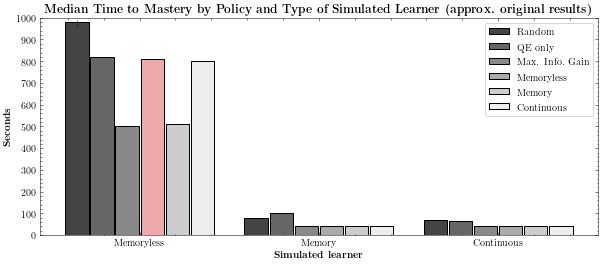

In [17]:
data_letter_orig = np.array([
    [980, 80, 70],
    [820, 100, 66],
    [500, 42.0, 42.0],
    [810, 42.0, 42.0],
    [510, 42.0, 42.0],
    [800, 42.0, 42.0]
])

data_letter_ci_orig = np.array([
    [[960.0, 990], [80, 80], [70, 70]],
    [[820, 820], [100, 100], [66, 66]],
    [[500, 500], [42, 42], [42, 42]],
    [[810, 810], [42, 42], [42, 42]],
    [[510, 510], [42, 42], [42, 42]],
    [[800, 800], [42, 42], [42, 42]],
])

with plt.style.context(['science']):
    plt.figure(figsize=(10,4))
    plot_policy_median_times_orig(data_letter_orig, data_cats,
                             'Median Time to Mastery by Policy and Type of Simulated Learner (approx. original results)', 
                             'median-time-letter-orig', ymax=1000, error_bars=data_letter_ci_orig, highlight=[4])
    plt.savefig('figures/median-time-letter-orig-small.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

# Number game: multiples of 7

### No precomputation - orig space

In [18]:
data_mul7, data_mul7_ci = \
    read_times_from_json('./data/number_game/no_pre_orig_concepts/mul7')
data_6483, data_6483_ci = \
    read_times_from_json('./data/number_game/no_pre_orig_concepts/range64-83')
data_mul41, data_mul41_ci = \
    read_times_from_json('./data/number_game/no_pre_orig_concepts/mul4-1')


In [19]:
datang_mless = np.stack([
    data_mul7[:, 0],
    data_mul41[:, 0],
    data_6483[:, 0],
]).T
datang_mless_ci = np.transpose(np.stack([
    data_mul7_ci[:, 0],
    data_mul41_ci[:, 0],
    data_6483_ci[:, 0],
]), axes=[1, 0, 2])

datang_discrete = np.stack([
    data_mul7[:, 1],
    data_mul41[:, 1],
    data_6483[:, 1],
]).T
datang_discrete_ci = np.transpose(np.stack([
    data_mul7_ci[:, 1],
    data_mul41_ci[:, 1],
    data_6483_ci[:, 1],
]), axes=[1, 0, 2])

datang_continuous = np.stack([
    data_mul7[:, 2],
    data_mul41[:, 2],
    data_6483[:, 2],
]).T
datang_continuous_ci = np.transpose(np.stack([
    data_mul7_ci[:, 2],
    data_mul41_ci[:, 2],
    data_6483_ci[:, 2],
]), axes=[1, 0, 2])

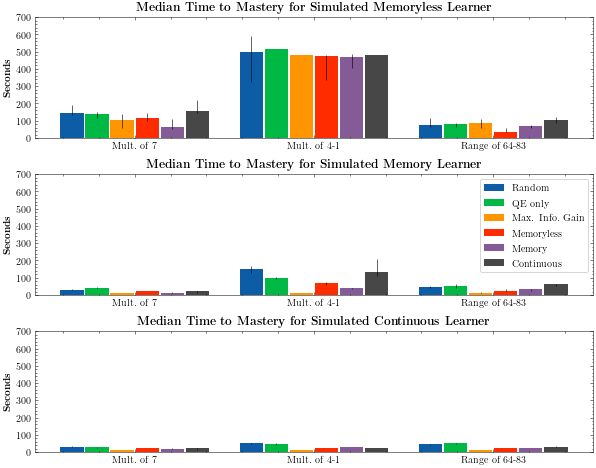

In [20]:
with plt.style.context('science'):
    plt.figure(figsize=(10,8))
    plt.subplot(3, 1, 1)
    plot_policy_median_times(datang_mless, data_cats,
                             'Median Time to Mastery for Simulated Memoryless Learner',
                             'median-time-ng-mless', ymax=700, x_label='', error_bars=datang_mless_ci.copy(),
                             group_labels=['Mult. of 7', 'Mult. of 4-1', 'Range of 64-83'], legend=False)
    #plt.legend(frameon=True, loc=(0.005, .25))

    plt.subplot(3, 1, 2)
    plot_policy_median_times(datang_discrete, data_cats,
                             'Median Time to Mastery for Simulated Memory Learner',
                             'median-time-ng-discrete', ymax=700, x_label='', error_bars=datang_discrete_ci.copy(),
                             group_labels=['Mult. of 7', 'Mult. of 4-1', 'Range of 64-83'], legend=True)

    plt.subplot(3, 1, 3)
    plot_policy_median_times(datang_continuous, data_cats,
                             'Median Time to Mastery for Simulated Continuous Learner',
                             'median-time-ng-continuous', ymax=700, x_label='', error_bars=datang_continuous_ci.copy(),
                             group_labels=['Mult. of 7', 'Mult. of 4-1', 'Range of 64-83'], legend=False)

    plt.subplots_adjust(hspace=.3)
    plt.savefig('figures/median-time-ng-orig.pdf')
    plt.show()
    

In [21]:
ng_mul7_actions_mless, ng_mul7_actions_disc, ng_mul7_actions_cont = \
    read_action_stats_from_jsons('/home/lukas/Development/Studium/FasterTeaching/data/number_game/no_pre_orig_concepts/mul7', 200)
ng_6483_actions_mless, ng_6483_actions_disc, ng_6483_actions_cont = \
    read_action_stats_from_jsons('/home/lukas/Development/Studium/FasterTeaching/data/number_game/no_pre_orig_concepts/range64-83', 200)
ng_mul41_actions_mless, ng_mul41_actions_disc, ng_mul41_actions_cont = \
    read_action_stats_from_jsons('/home/lukas/Development/Studium/FasterTeaching/data/number_game/no_pre_orig_concepts/mul4-1', 200)

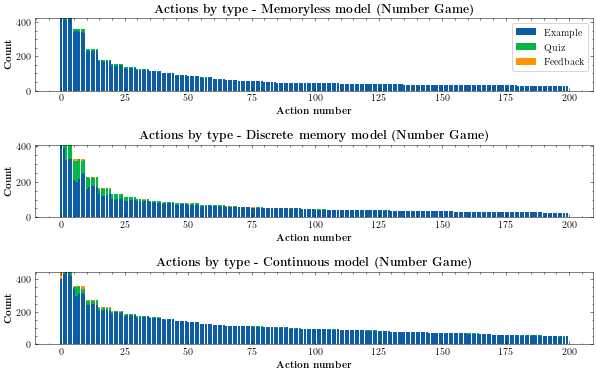

In [22]:

ng_actions_mless = ng_mul41_actions_mless+ng_mul7_actions_mless+ng_6483_actions_mless
ng_actions_disc = ng_mul41_actions_disc+ng_mul7_actions_disc+ng_6483_actions_disc
ng_actions_cont = ng_mul41_actions_cont+ng_mul7_actions_cont+ng_6483_actions_cont

with plt.style.context('science'):
    plt.figure(figsize=(10,6))
    plt.subplot(311)
    plot_actions(ng_actions_mless, r'\textbf{Actions by type - Memoryless model (Number Game)}')
    #plt.suptitle(r'\textbf{Planned actions per policy for the Number Game}')
    plt.subplot(312)
    plot_actions(ng_actions_disc, r'\textbf{Actions by type - Discrete memory model (Number Game)}',
                 legend=False)
    plt.subplot(313)
    plot_actions(ng_actions_cont, r'\textbf{Actions by type - Continuous model (Number Game)}', legend=False)
    plt.subplots_adjust(hspace=.75)
    plt.savefig("figures/ng-actions-orig.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

### With precomputation - explainable space

In [23]:
from tabulate import tabulate
from functools import reduce

In [24]:
data_mul7 = np.array([
            [224.8, 33.4, 32.0],
            [130.2, 38.4, 26.6],
            [168.0, 12.0, 12.0],
            [120.6, 12.0, 12.0],
            [ 90.0, 12.0, 12.0],
            [192.0, 12.0, 12.0]])

data_mul7_ci = np.array([
    [[196.8, 284.2], [30.8, 37.0], [29.4, 34.0]],
    [[116.4, 146.0], [38.0, 39.2], [26.0, 32.8]],
    [[132, 204], [12, 12], [12, 12]],
    [[96.8, 140.2], [12, 12], [12, 12]],
    [[72, 108], [12, 12], [12, 12]],
    [[144, 270], [12, 12], [12, 12]],
])

In [25]:
# cont model
ng7_actions_cont_cont = [[50, 50, 50, 50, 50, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ng7_actions_cont_disc = [[50, 50, 50, 50, 50, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ng7_actions_cont_mless = [[50, 50, 50, 50, 50, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 40, 40, 40, 40, 40, 38, 38, 38, 38, 38, 37, 37, 37, 37, 37, 35, 35, 35, 35, 35, 34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 30, 30, 30, 30, 30, 28, 28, 28, 28, 28, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

ng7_actions_cont = np.zeros((200, 3))
[[[add_action(ng7_actions_cont, step, t, count)
 for step, count in enumerate(seq)] for t, seq in enumerate(var)]
 for var in [ng7_actions_cont_cont, ng7_actions_cont_disc, ng7_actions_cont_mless]]

# discrete memory model
ng7_actions_disc_cont = [[50, 50, 50, 50, 50, 4, 4, 4, 4, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ng7_actions_disc_disc = [[50, 50, 50, 50, 50], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
ng7_actions_disc_mless = [[50, 50, 50, 50, 50, 38, 38, 38, 38, 38, 37, 37, 37, 37, 37, 36, 36, 36, 36, 36, 34, 34, 34, 34, 34, 31, 31, 31, 31, 31, 28, 28, 28, 28, 28, 25, 25, 25, 25, 25, 23, 23, 23, 23, 23, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

ng7_actions_disc = np.zeros((200, 3))
[[[add_action(ng7_actions_disc, step, t, count)
 for step, count in enumerate(seq)]
 for t, seq in enumerate(var)]
 for var in [ng7_actions_disc_cont, ng7_actions_disc_disc, ng7_actions_disc_mless]]

# mless model
ng7_actions_mless_cont = [[50, 50, 50, 50, 50, 15, 15, 15, 15, 15], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ng7_actions_mless_disc = [[50, 50, 50, 50, 50, 11, 11, 11, 11, 11, 4, 4, 4, 4, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ng7_actions_mless_mless = [[50, 50, 50, 50, 50, 47, 47, 47, 47, 47, 40, 40, 40, 40, 40, 36, 36, 36, 36, 36, 30, 31, 30, 32, 33, 30, 32, 28, 34, 31, 30, 29, 29, 31, 29, 26, 27, 23, 26, 27, 27, 26, 26, 27, 27, 25, 27, 25, 26, 25, 22, 20, 22, 20, 22, 22, 21, 20, 19, 22, 20, 19, 18, 19, 20, 18, 19, 17, 18, 18, 19, 18, 19, 19, 18, 15, 16, 16, 16, 16, 13, 13, 12, 13, 13, 13, 13, 13, 12, 13, 12, 12, 12, 12, 12, 11, 12, 12, 12, 12, 11, 11, 11, 11, 11, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 5, 6, 4, 3, 5, 3, 7, 1, 4, 2, 3, 3, 1, 3, 3, 2, 6, 3, 2, 1, 2, 2, 1, 1, 2, 0, 2, 1, 2, 1, 3, 1, 3, 1, 0, 1, 2, 3, 0, 0, 1, 2, 1, 0, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

ng7_actions_mless = np.zeros((200, 3))
[[[add_action(ng7_actions_mless, step, t, count)
 for step, count in enumerate(seq)]
 for t, seq in enumerate(var)]
 for var in [ng7_actions_mless_cont, ng7_actions_mless_disc, ng7_actions_mless_mless]]
print()

In [26]:
data_6483 = np.array([
[ 98.6, 57.4, 42.0],
[ 77.8, 58.6, 51.6],
[108.0, 12.0, 12.0],
[ 60.0, 24.0, 24.0],
[ 24.0, 24.0, 24.0],
[ 94.0, 48.8, 24.4]])

data_6483_ci = np.array([
    [[88.8, 123.2], [49.6, 67.7], [34.8, 47.8]],
    [[58.4, 91.6], [51.8, 65.6], [50.4, 52.4]],
    [[96, 156], [12, 12], [12, 12]],
    [[36.0, 60], [24, 24], [24, 24]],
    [[24, 24], [12, 24], [24, 24]],
    [[63.2, 129], [38, 56.6], [24.4, 24.8]],
])


In [27]:
# cont model
ng6483_actions_cont_cont = [[50, 50, 50, 50, 50, 33, 0, 27, 29, 24, 15, 14, 13, 16, 16, 9, 5, 6, 7, 7, 3, 3, 4, 3, 3, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 33, 4, 4, 8, 3, 2, 4, 1, 3, 1, 2, 4, 3, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 3, 2, 2, 0, 0, 3, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ng6483_actions_cont_disc = [[50, 50, 50, 50, 50, 42, 0, 33, 33, 33, 20, 23, 28, 22, 26, 23, 20, 19, 22, 22, 20, 18, 17, 20, 18, 13, 15, 16, 17, 18, 13, 16, 13, 16, 15, 15, 13, 14, 16, 15, 12, 12, 10, 12, 11, 7, 8, 7, 8, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 42, 7, 7, 7, 12, 11, 5, 9, 6, 2, 4, 6, 3, 2, 1, 2, 3, 0, 4, 4, 2, 2, 1, 0, 2, 0, 2, 0, 1, 1, 3, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 3, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ng6483_actions_cont_mless = [[50, 50, 50, 50, 50, 39, 0, 33, 31, 29, 24, 24, 23, 23, 27, 22, 25, 25, 26, 28, 27, 26, 21, 24, 26, 19, 22, 23, 23, 22, 23, 24, 24, 26, 24, 23, 21, 22, 24, 23, 24, 24, 23, 23, 22, 23, 23, 22, 23, 22, 20, 19, 19, 20, 19, 16, 18, 18, 18, 18, 17, 17, 17, 17, 17, 15, 14, 14, 15, 15, 14, 14, 14, 14, 14, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 9, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 0, 0, 0, 0, 0, 39, 6, 6, 9, 7, 7, 10, 6, 3, 7, 5, 5, 2, 3, 3, 3, 9, 5, 3, 4, 2, 4, 4, 2, 3, 1, 1, 0, 1, 1, 3, 2, 0, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 0, 4, 3, 2, 1, 1, 3, 0, 0, 1, 0, 1, 1, 4, 3, 0, 0, 3, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

ng6483_actions_cont = np.zeros((200, 3))
[[[add_action(ng6483_actions_cont, step, t, count)
 for step, count in enumerate(seq)] for t, seq in enumerate(var)]
 for var in [ng6483_actions_cont_cont, ng6483_actions_cont_disc, ng6483_actions_cont_mless]]

# discrete memory model
ng6483_actions_disc_cont = [[50, 50, 50, 50, 50, 31, 31, 31, 31, 31, 10, 10, 10, 10, 10], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ng6483_actions_disc_disc = [[50, 50, 50, 50, 50, 26, 26, 26, 26, 26, 9, 9, 9, 9, 9, 6, 6, 6, 6, 6, 2, 2, 1, 1, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ng6483_actions_disc_mless = [[50, 50, 50, 50, 50, 32, 32, 32, 32, 32, 23, 23, 23, 23, 23, 21, 21, 21, 21, 21, 19, 19, 18, 18, 18, 17, 16, 16, 16, 17, 14, 14, 14, 13, 14, 12, 12, 12, 11, 12, 11, 11, 11, 11, 10, 8, 6, 8, 9, 9, 8, 8, 9, 9, 8, 7, 9, 9, 9, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 3, 1, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

ng6483_actions_disc = np.zeros((200, 3))
[[[add_action(ng6483_actions_disc, step, t, count)
 for step, count in enumerate(seq)]
 for t, seq in enumerate(var)]
 for var in [ng6483_actions_disc_cont, ng6483_actions_disc_disc, ng6483_actions_disc_mless]]

# mless model
ng6483_actions_mless_cont = [[50, 50, 50, 50, 50, 35, 35, 35, 35, 35, 13, 13, 13, 13, 13, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ng6483_actions_mless_disc = [[50, 50, 50, 50, 50, 32, 32, 32, 32, 32, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ng6483_actions_mless_mless = [[50, 50, 50, 50, 50, 35, 35, 35, 35, 35, 32, 32, 32, 32, 32, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 21, 21, 21, 21, 21, 17, 17, 17, 17, 17, 13, 13, 13, 13, 13, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

ng6483_actions_mless = np.zeros((200, 3))
[[[add_action(ng6483_actions_mless, step, t, count)
 for step, count in enumerate(seq)]
 for t, seq in enumerate(var)]
 for var in [ng6483_actions_mless_cont, ng6483_actions_mless_disc, ng6483_actions_mless_mless]]

print()

In [28]:
data_mul41 = np.array([
[641.0, 166.2, 51.6],
[515.4,  91.4, 45.8],
[480.0,  12.0, 12.0],
[480.0,  48.0, 12.0],
[485.4,  41.6, 26.2],
[482.4, 230.4, 26.4]])

data_mul41_ci = np.array([
    [[538.1, 656.1], [143.4, 208.4], [45, 54.6]],
    [[428, 516.8], [89.6, 104], [39.6, 52]],
    [[480, 480], [12, 12], [12, 12]],
    [[480, 480], [18, 66], [12, 12]],
    [[485, 487.2], [38.8, 50.6], [26, 26.4]],
    [[482.4, 482.4], [194.4, 285.6], [26.4, 26.4]],
])


In [29]:
# cont model
ngmul41_actions_cont_cont = [[0, 49, 47, 49, 49, 33, 34, 34, 34, 34, 11, 11, 11, 11, 11, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [50, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ngmul41_actions_cont_disc = [[0, 49, 47, 50, 49, 44, 44, 44, 44, 44, 42, 42, 42, 42, 42, 40, 40, 40, 40, 40, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 37, 37, 37, 37, 37, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [50, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ngmul41_actions_cont_mless = [[0, 49, 47, 50, 49, 49, 49, 49, 49, 49, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 40, 40, 40, 40, 40, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 37, 37, 37, 37, 37, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [50, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

ngmul41_actions_cont = np.zeros((200, 3))
[[[add_action(ngmul41_actions_cont, step, t, count)
 for step, count in enumerate(seq)] for t, seq in enumerate(var)]
 for var in [ngmul41_actions_cont_cont, ngmul41_actions_cont_disc, ngmul41_actions_cont_mless]]

# discrete memory model
ngmul41_actions_disc_cont = [[50, 50, 0, 17, 16, 14, 13, 18, 17, 22, 7, 7, 5, 6, 7, 0, 3, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 0, 1, 0], [0, 0, 50, 30, 32, 21, 23, 21, 19, 15, 6, 6, 8, 3, 6, 3, 0, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1], [0, 0, 0, 3, 2, 4, 3, 0, 3, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
ngmul41_actions_disc_disc = [[50, 50, 0, 21, 15, 17, 16, 22, 18, 15, 14, 16, 12, 13, 17, 8, 12, 11, 13, 13, 8, 7, 9, 12, 13, 9, 5, 7, 7, 8, 3, 6, 5, 6, 4, 4, 3, 5, 4, 4, 4, 3, 2, 5, 4, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 0, 0, 1, 1, 1], [0, 0, 50, 27, 32, 22, 23, 19, 19, 23, 16, 12, 15, 15, 12, 14, 11, 12, 10, 10, 8, 7, 8, 5, 4, 3, 7, 5, 5, 4, 5, 2, 2, 2, 4, 3, 4, 2, 3, 3, 1, 2, 3, 0, 1, 2, 2, 1, 2, 1, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 2, 3, 3, 3, 1, 5, 4, 0, 2, 3, 2, 1, 1, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]]
ngmul41_actions_disc_mless = [[50, 50, 0, 21, 15, 20, 19, 25, 21, 23, 24, 31, 22, 28, 29, 25, 33, 28, 25, 32, 29, 33, 34, 33, 35, 36, 34, 37, 37, 38, 35, 32, 32, 39, 38, 37, 40, 35, 33, 40, 39, 37, 38, 44, 40, 41, 38, 42, 41, 44, 43, 42, 43, 43, 45, 45, 43, 43, 43, 43, 44, 44, 44, 46, 46, 42, 45, 44, 45, 45, 45, 44, 45, 46, 45, 45, 44, 45, 45, 46, 45, 45, 44, 44, 44, 43, 46, 45, 44, 45, 43, 43, 45, 44, 44, 45, 45, 44, 46, 45, 44, 45, 45, 46, 46, 43, 44, 43, 44, 43, 44, 44, 44, 44, 43, 42, 44, 44, 43, 43, 43, 44, 44, 43, 42, 43, 43, 42, 42, 42, 42, 42, 42, 43, 43, 41, 41, 41, 41, 41, 41, 41, 42, 41, 42, 39, 39, 39, 40, 40, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38, 38, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37], [0, 0, 50, 27, 32, 29, 25, 25, 24, 23, 25, 18, 26, 19, 19, 24, 16, 19, 25, 18, 21, 15, 13, 14, 14, 12, 13, 11, 12, 10, 13, 15, 14, 9, 10, 9, 7, 11, 13, 7, 8, 9, 9, 3, 7, 6, 9, 5, 5, 3, 4, 5, 4, 4, 2, 2, 4, 4, 3, 2, 2, 3, 3, 1, 1, 5, 2, 3, 2, 2, 2, 3, 2, 1, 1, 2, 3, 1, 2, 1, 1, 1, 2, 2, 2, 3, 0, 1, 2, 1, 3, 3, 1, 2, 2, 1, 1, 2, 0, 1, 2, 1, 1, 0, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 3, 1, 6, 0, 5, 4, 1, 1, 2, 3, 2, 1, 1, 3, 0, 0, 0, 2, 3, 3, 1, 1, 2, 1, 0, 1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

ngmul41_actions_disc = np.zeros((200, 3))
[[[add_action(ngmul41_actions_disc, step, t, count)
 for step, count in enumerate(seq)]
 for t, seq in enumerate(var)]
 for var in [ngmul41_actions_disc_cont, ngmul41_actions_disc_disc, ngmul41_actions_disc_mless]]

# mless model
ngmul41_actions_mless_cont = [[50, 50, 50, 50, 50, 14, 14, 14, 14, 14, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ngmul41_actions_mless_disc = [[50, 50, 50, 50, 50, 29, 29, 29, 29, 29, 26, 26, 26, 26, 26, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 22, 22, 22, 22, 22, 17, 17, 17, 17, 17, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ngmul41_actions_mless_mless = [[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 48, 48, 48, 48, 48, 47, 47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 44, 44, 44, 44, 44, 43, 43, 43, 43, 43, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 41, 41, 41, 41, 41, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 37, 37, 37, 37, 37, 36, 36, 36, 36, 36], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

ngmul41_actions_mless = np.zeros((200, 3))
[[[add_action(ngmul41_actions_mless, step, t, count)
 for step, count in enumerate(seq)]
 for t, seq in enumerate(var)]
 for var in [ngmul41_actions_mless_cont, ngmul41_actions_mless_disc, ngmul41_actions_mless_mless]]

print()

In [30]:
medians = reduce(lambda x, carry: x+carry, data_mul7.tolist())
cis = reduce(lambda x, carry: x+carry, data_mul7_ci.tolist())
combined_mul7 = [[md, ci[0], ci[1]] for md, ci in zip(medians, cis)]

medians = reduce(lambda x, carry: x+carry, data_mul41.tolist())
cis = reduce(lambda x, carry: x+carry, data_mul41_ci.tolist())
combined_mul41 = [[md, ci[0], ci[1]] for md, ci in zip(medians, cis)]

medians = reduce(lambda x, carry: x+carry, data_6483.tolist())
cis = reduce(lambda x, carry: x+carry, data_6483_ci.tolist())
combined_rg = [[md, ci[0], ci[1]] for md, ci in zip(medians, cis)]

tbl = []
for els in zip(combined_mul7, combined_mul41, combined_rg):
    tbl.append(["{:.2f} [{:.2f} {:.2f}]".format(*el) for el in els])
    
print(tabulate(tbl, tablefmt='latex'))

\begin{tabular}{lll}
\hline
 224.80 [196.80 284.20] & 641.00 [538.10 656.10] & 98.60 [88.80 123.20]  \\
 33.40 [30.80 37.00]    & 166.20 [143.40 208.40] & 57.40 [49.60 67.70]   \\
 32.00 [29.40 34.00]    & 51.60 [45.00 54.60]    & 42.00 [34.80 47.80]   \\
 130.20 [116.40 146.00] & 515.40 [428.00 516.80] & 77.80 [58.40 91.60]   \\
 38.40 [38.00 39.20]    & 91.40 [89.60 104.00]   & 58.60 [51.80 65.60]   \\
 26.60 [26.00 32.80]    & 45.80 [39.60 52.00]    & 51.60 [50.40 52.40]   \\
 168.00 [132.00 204.00] & 480.00 [480.00 480.00] & 108.00 [96.00 156.00] \\
 12.00 [12.00 12.00]    & 12.00 [12.00 12.00]    & 12.00 [12.00 12.00]   \\
 12.00 [12.00 12.00]    & 12.00 [12.00 12.00]    & 12.00 [12.00 12.00]   \\
 120.60 [96.80 140.20]  & 480.00 [480.00 480.00] & 60.00 [36.00 60.00]   \\
 12.00 [12.00 12.00]    & 48.00 [18.00 66.00]    & 24.00 [24.00 24.00]   \\
 12.00 [12.00 12.00]    & 12.00 [12.00 12.00]    & 24.00 [24.00 24.00]   \\
 90.00 [72.00 108.00]   & 485.40 [485.00 487.20] & 24.00 [24

In [31]:
datang_mless = np.stack([
    data_mul7[:, 0],
    data_mul41[:, 0],
    data_6483[:, 0],
]).T
datang_mless_ci = np.transpose(np.stack([
    data_mul7_ci[:, 0],
    data_mul41_ci[:, 0],
    data_6483_ci[:, 0],
]), axes=[1, 0, 2])


In [32]:
datang_discrete = np.stack([
    data_mul7[:, 1],
    data_mul41[:, 1],
    data_6483[:, 1],
]).T
datang_discrete_ci = np.transpose(np.stack([
    data_mul7_ci[:, 1],
    data_mul41_ci[:, 1],
    data_6483_ci[:, 1],
]), axes=[1, 0, 2])


In [33]:
datang_continuous = np.stack([
    data_mul7[:, 2],
    data_mul41[:, 2],
    data_6483[:, 2],
]).T
datang_continuous_ci = np.transpose(np.stack([
    data_mul7_ci[:, 2],
    data_mul41_ci[:, 2],
    data_6483_ci[:, 2],
]), axes=[1, 0, 2])


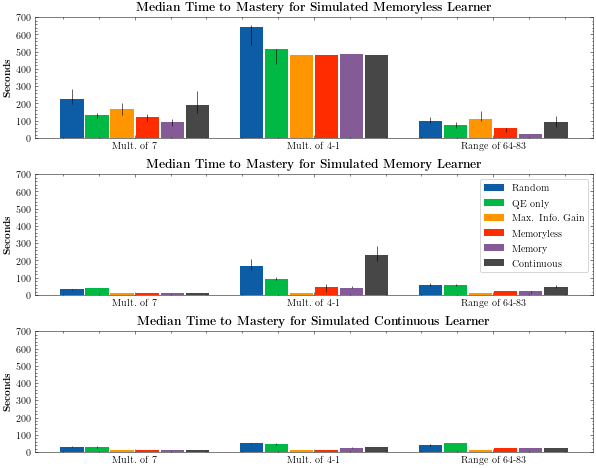

In [34]:

with plt.style.context('science'):
    plt.figure(figsize=(10,8))
    plt.subplot(3, 1, 1)
    plot_policy_median_times(datang_mless, data_cats,
                             'Median Time to Mastery for Simulated Memoryless Learner',
                             'median-time-ng-mless', ymax=700, x_label='', error_bars=datang_mless_ci.copy(),
                             group_labels=['Mult. of 7', 'Mult. of 4-1', 'Range of 64-83'], legend=False)
    #plt.legend(frameon=True, loc=(0.005, .25))

    plt.subplot(3, 1, 2)
    plot_policy_median_times(datang_discrete, data_cats,
                             'Median Time to Mastery for Simulated Memory Learner',
                             'median-time-ng-discrete', ymax=700, x_label='', error_bars=datang_discrete_ci.copy(),
                             group_labels=['Mult. of 7', 'Mult. of 4-1', 'Range of 64-83'], legend=True)

    plt.subplot(3, 1, 3)
    plot_policy_median_times(datang_continuous, data_cats,
                             'Median Time to Mastery for Simulated Continuous Learner',
                             'median-time-ng-continuous', ymax=700, x_label='', error_bars=datang_continuous_ci.copy(),
                             group_labels=['Mult. of 7', 'Mult. of 4-1', 'Range of 64-83'], legend=False)

    plt.subplots_adjust(hspace=.3)
    plt.savefig('figures/median-time-ng-pre.pdf')
    plt.show()
    

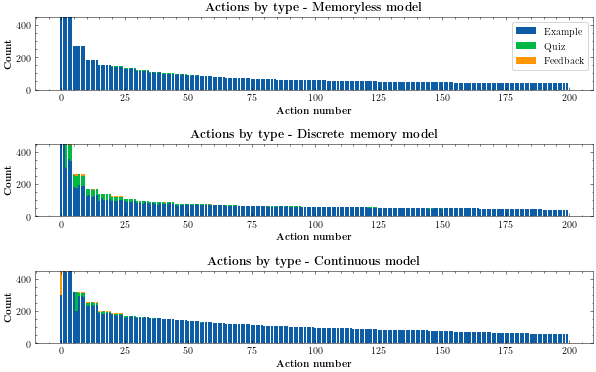

In [35]:

ng_actions_mless = ngmul41_actions_mless+ng7_actions_mless+ng6483_actions_mless
ng_actions_disc = ngmul41_actions_disc+ng7_actions_disc+ng6483_actions_disc
ng_actions_cont = ngmul41_actions_cont+ng7_actions_cont+ng6483_actions_cont

with plt.style.context('science'):
    plt.figure(figsize=(10,6))
    plt.subplot(311)
    plot_actions(ng_actions_mless, r'\textbf{Actions by type - Memoryless model}')
    #plt.suptitle(r'\textbf{Planned actions per policy for the Number Game}')
    plt.subplot(312)
    plot_actions(ng_actions_disc, r'\textbf{Actions by type - Discrete memory model}',
                 legend=False)
    plt.subplot(313)
    plot_actions(ng_actions_cont, r'\textbf{Actions by type - Continuous model}', legend=False)
    plt.subplots_adjust(hspace=.75)
    plt.savefig("figures/ng-actions-pre.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

## Original data

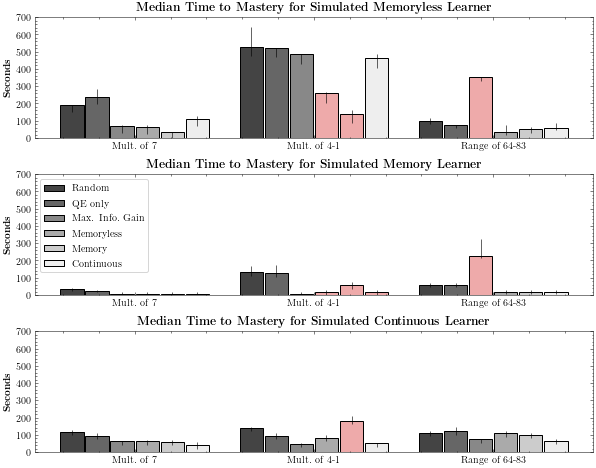

In [37]:
datang_mless_orig = np.array([
    [192.0, 526, 100],
    [239, 522, 78],
    [68, 484, 351],
    [61, 258, 37],
    [37, 141, 50],
    [112, 461, 58]
])

datang_mless_ci_orig = np.array([
    [[151.0, 192], [473, 642], [80, 116]],
    [[196, 285], [468, 522], [58, 78]],
    [[27, 76], [428, 484], [330, 351]],
    [[22, 76], [205, 268], [18, 78]],
    [[0, 37], [85, 161], [31, 62]],
    [[71, 125], [406, 486], [45, 85]],
])

datang_disc_orig = np.array([
    [32, 136, 56],
    [24, 128, 56],
    [8, 8, 228],
    [8, 20, 20],
    [8, 60, 20],
    [8, 16, 20.0]
])

datang_disc_ci_orig = np.array([
    [[24, 40], [112, 168], [48, 72]],
    [[16, 28], [104, 172], [44, 68]],
    [[0, 16], [0, 16], [212, 324]],
    [[0, 16], [0, 28], [8, 28]],
    [[0, 16], [36, 76], [8, 28]],
    [[0, 16], [0, 28], [8, 28.0]],
])

datang_cont_orig = np.array([
    [116, 138, 113],
    [94, 94, 121],
    [62, 44, 74],
    [62, 82, 110],
    [61, 179, 97],
    [39, 50, 63.0]
])

datang_cont_ci_orig = np.array([
    [[96.0, 128], [124, 148], [92, 120]],
    [[76, 108], [76, 108], [100, 148]],
    [[40, 64], [28, 52], [52, 76]],
    [[40, 68], [64, 100], [88, 124]],
    [[40, 68], [160, 208], [80, 112]],
    [[16, 56], [32, 52], [44, 76]],
])

with plt.style.context('science'):
    plt.figure(figsize=(10,8))
    plt.subplot(3, 1, 1)
    plot_policy_median_times_orig(datang_mless_orig, data_cats,
                             'Median Time to Mastery for Simulated Memoryless Learner',
                             'median-time-ng-mless', ymax=700, x_label='', error_bars=datang_mless_ci_orig.copy(),
                             group_labels=['Mult. of 7', 'Mult. of 4-1', 'Range of 64-83'], legend=False,
                            highlight=[10, 11, 15])
    #plt.legend(frameon=True, loc=(0.005, .25))

    plt.subplot(3, 1, 2)
    plot_policy_median_times_orig(datang_disc_orig, data_cats,
                             'Median Time to Mastery for Simulated Memory Learner',
                             'median-time-ng-discrete', ymax=700, x_label='', error_bars=datang_disc_ci_orig.copy(),
                             group_labels=['Mult. of 7', 'Mult. of 4-1', 'Range of 64-83'], legend=True,
                            highlight=[10, 11, 12, 15])

    plt.subplot(3, 1, 3)
    plot_policy_median_times_orig(datang_cont_orig, data_cats,
                             'Median Time to Mastery for Simulated Continuous Learner',
                             'median-time-ng-continuous', ymax=700, x_label='', error_bars=datang_cont_ci_orig.copy(),
                             group_labels=['Mult. of 7', 'Mult. of 4-1', 'Range of 64-83'], legend=False,
                            highlight=[11])

    plt.subplots_adjust(hspace=.3)
    plt.savefig('figures/median-time-ng-orig.pdf')
    plt.show()